# Building a Neural Network from Scratch

**Motivation:** In order to grasp and deeply understand several concepts of Deep Learning I decided to implement a Neural Network from scratch using only the library NumPy. This work will help me to internally visualize what's happening "behind doors" when using Deep Learning oriented libraries like TensorFlow and PyTorch.  

In [1]:
#Import the libraries
import numpy as np
import matplotlib.pyplot as plt

## Exploring the dataset

In [109]:
#Import a dataset from scikit-learn
#The dataset that I am going to use is simply a 2-D non-linear binary classification dataset
import sklearn.datasets
from sklearn.metrics import f1_score

X,y = sklearn.datasets.make_moons(200, noise=0.15)

In [3]:
print(X.shape,type(X))
print(y.shape,type(y))

(200, 2) <class 'numpy.ndarray'>
(200,) <class 'numpy.ndarray'>


The dataset has 200 instances and 2 features.

**Plot the data**

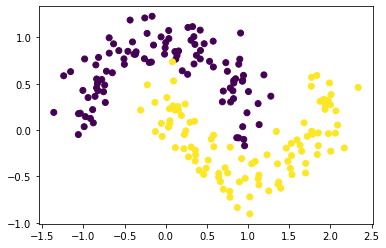

In [4]:
plt.scatter(X[:,0], X[:,1], c=y)

## Building the network architecture and defining functions

The network that I decided to build has 2 input neurons (equal to the number of features),
1 hidden layer with 3 hidden neurons and 2 output neurons (since I'm going to implement SoftMax).

Defining the hyperparameters,

In [5]:
#Number of input neurons
input_neurons = 2
#Number of output neurons
output_neurons = 2
#Number of samples (in this case 200)
samples = X.shape[0]
#Learning Rate
learning_rate = 0.001
#Regularization term constant
lambda_reg = 0.01

#Model dictionary that stores the weights and biases of the model

model_dict = {'W1':W1, 'b1':b1, 'W2':W2, 'b2':b2}

In [6]:
''' Function that outputs the weights and biases of the model
    W1 -> weights of the first layer
    W2 -> weights of the second layer
    b1 -> biases of the first layer
    b2 -> biases of the second layer'''

def retrieve(model_dict):
    W1 = model_dict['W1']
    b1 = model_dict['b1']
    W2 = model_dict['W2']
    b2 = model_dict['b2']
    return W1,b1,W2,b2

**Forward Propagation**

In [7]:
''' Function that performs forward propagation
    Inputs: x -> input data
            model_dict -> model dictionary
    Outputs: z1 -> First Layer Outputs
             a1 -> Second Layer Inputs
             softmax -> Output probabilities'''

def forward(x, model_dict):
    #Weights and biases of the network
    W1, b1, W2, b2 = retrieve(model_dict)
    #Output of the first layer/Input of the hidden layer
    z1 = x.dot(W1) + b1  # (200x2).(2x3) -> (200x3)
    #Activation of the hidden layer neurons/Inputs of the second layer
    a1 = np.tanh(z1)  # (200x3)
    #Outputs of the second layer/Pre-activated outputs of the model
    z2 = a1.dot(W2) + b2 # (200x3).(3x2) -> (200x2) -> softmax dimensions
    #Apply the exponential for all the output values
    exp_scores = np.exp(z2)
    #Aplly softmax to the output values (axis = 1 => sum along the columns)
    #Since I will use Softmax, I will use the maximum of the softmax has my prediction
    softmax = exp_scores / np.sum(exp_scores, axis=1, keepdims = True) #each output values sum up to 1
                                                                       #for each instance
    
    return z1, a1, softmax

**Loss Calculation (Cross Entropy Loss)**

Note: Cross Entropy only considers the loss for correct samples. So, with Cross Entropy Loss we always want the probabilities to be high, since we are always considering the correct label.

In [145]:
''' Definition of the Cross Entropy Loss
    Inputs: softmax -> predicted probabilities
            y -> actual labels
            model_dict -> model dictionary
    Outputs: Cross Entropy Loss Value'''

def loss(softmax, y, model_dict):
    #Weights of the network, useful for regularization
    W1, b1, W2, b2 = retrieve(model_dict)
    #Initialize the vector that will contain the probabilities (softmax)
    #of the correct label
    m = np.zeros(len(y))
    #Loop to create the vector with the probabilities of the actual label
    for i, correct_label in enumerate(y):
        #Picks the probability of the correct label
        predicted = softmax[i][correct_label]
        m[i] = predicted
    
    #Calculate the softmax loss
    log_prob = -np.log(m)
    softmax_loss = np.sum(log_prob)
    #Regularization Loss
    reg_loss = (lambda_reg/2) * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    loss = softmax_loss + reg_loss
    
    return float(loss / y.shape[0])      

For the model predictions one choose the class corresponding to the maximum of the softmax output values for every instance.

In [9]:
''' Function that calculates the predictions
    Inputs: model_dict -> model dictionary
            x -> input data
    Output: Model Predicted Labels'''

def predict(model_dict, x):
    #Model Weights and Biases
    W1, b1, W2, b2 = retrieve(model_dict)
    #Output of the first layer/Input of the hidden layer
    z1 = x.dot(W1) + b1
    #Activation of the hidden layer neurons/Inputs of the second layer
    a1 = np.tanh(z1)  
    #Outputs of the second layer/Pre-activated outputs of the model
    z2 = a1.dot(W2) + b2
    
    #Apply sofmax
    exp_scores = np.exp(z2)
    softmax = exp_scores / np.sum(exp_scores, axis=1, keepdims = True) # (200,2)
    
    return np.argmax(softmax, axis = 1) #returns the argument of the maximum probability for each instance


**Back Propagation**

![backprop](https://user-images.githubusercontent.com/30661597/67566804-3e405980-f75b-11e9-9e19-f3c388745c0a.png)

$\frac{\partial L}{\partial y_{1}}=-\tilde{y}_{1}\left[\frac{\left(y_{1}\right)^{\prime}}{y_{1}}\right]=-\tilde{y}_{1}\left[\frac{1}{y_{1}}\right]$

$\frac{\partial y_{1}}{\partial z_{1}}=\frac{\partial}{\partial z_{1}} \cdot \frac{e^{z_{1}}}{e^{z_{1}}+e^{z_{2}}+e^{z_{3}}}$

![der](https://user-images.githubusercontent.com/46392773/56460220-ec94cc00-63d1-11e9-91d1-b4e3c57c81fd.png)


 $\frac{\partial L}{\partial y_{1}} \frac{\partial y_{1}}{\partial z_{1}}=-\tilde{y}_{1}\left[\frac{1}{y_{1}}\right]\frac{\partial y_{1}}{\partial z_{1}}=-\tilde{y}_{1}\left[\frac{y_{1}\left(1-y_{1}\right)}{y_{1}}\right]=-\tilde{y}_{1}\left(1-y_{1}\right)$

Recall that our labels are in the form of a one-hot vector: (ex. If class 1 is correct, then the corresponding label is [1,0], if class 2 is correct, then the corresponding label is [0,1]).

If class one is the actual prediction: $\tilde{y}_{1} = 1 $, then we have:

$\frac{\partial L}{\partial y_{1}} \frac{\partial y_{1}}{\partial z_{1}} = -1(1-y_{1}) = y_{1} - 1 = \delta_{3}$

$\delta_{2}=\left(1-\tanh ^{2} z_{1}\right) \circ \delta_{3} W_{2}^{T}$

$\frac{\partial L}{\partial W_{2}}=a_{1}^{T} \delta_{3}$

$\frac{\partial L}{\partial b_{2}}=\delta_{3}$

$\frac{\partial L}{\partial W_{1}}=x^{T} \delta_{2}$

$\frac{\partial L}{\partial b_{1}}=\delta_{2}$

In [27]:
''' Function that calculates the batch gradients using backpropagation for each epoch and performs
    the corresponding weight updates
    Inputs: x -> input data
            y -> actual labels
            model_dict -> model_dictionary
            epochs -> total number of epochs
    Output: model_dict -> Dictionary containing the weights and biases of the optimized network'''

def backpropagation(x, y, model_dict, epochs):
    losses = []
    #For every distinct epoch
    for i in range(epochs):
        #Pre-updated weights and biases
        W1, b1, W2, b2 = retrieve(model_dict)
        #Forward Propagation
        z1, a1, probs = forward(x, model_dict) #z1/a1: (200x3), probs: (200x2)
        
        ### Definition of the backpropagation terms ###
        
        delta3 = np.copy(probs)
        delta3[range(x.shape[0]), y] -= 1   #(200x2)
        #Derivative of the cost function with respect to the weights
        #of the second layer 
        dW2 = (a1.T).dot(delta3)  #a1: (3,200)*(200,2)-->(3,2)
        #Derivative of the cost function with respect to the second layer bias terms
        db2 = np.sum(delta3, axis = 0, keepdims = True)   # (1,2)
        
        delta2 = delta3.dot(W2.T) * (1-np.power(np.tanh(z1), 2))
        #Derivative of the cost function with respect to the weights
        #of the first layer 
        dW1 = np.dot(x.T,delta2)
        #Derivative of the cost function with respect to the first layer bias terms
        db1 = np.sum(delta2, axis = 0)
        #Add regularization terms
        dW2 += lambda_reg * np.sum(W2)
        dW1 += lambda_reg * np.sum(W1)
        
        
        ### Update Weights ###
        # W = W - lr*gradient
        W1 += -learning_rate * dW1  
        b1 += -learning_rate * db1
        W2 += -learning_rate * dW2
        b2 += -learning_rate * db2
        #Update the model dictionary
        model_dict = {'W1':W1, 'b1':b1, 'W2':W2, 'b2':b2}
        #Save the loss value for each epoch
        losses.append(loss(probs, y, model_dict))
        #Print the Cross Entropy Loss every 50 epochs
        if i%50 == 0:
            print('Loss at epoch {} is {:.3f}'.format(i, loss(probs, y, model_dict)))
            
    return model_dict, losses                

**Weight Initialization (Xavier Initialization)**

In [28]:
''' Function that initializes the weights of the network
    Inputs: input_dim -> number of input neuron
            hidden_dim -> number of hidden neurons
            output_dim -> number of output neurons
    Output: model -> model dictionary with the initial weights and biases'''

def init_network(input_dim, hidden_dim, output_dim):
    model = {}
    #Xavier Initialization
    W1 = np.random.randn(input_dim, hidden_dim) / np.sqrt(input_dim)
    b1 = np.zeros((1, hidden_dim))
    W2 = np.random.randn(hidden_dim, output_dim) / np.sqrt(hidden_dim)
    b2 = np.zeros((1, output_dim))
    #Create model dictionary
    model['W1'] = W1
    model['b1'] = b1
    model['W2'] = W2
    model['b2'] = b2
    
    return model

## Training the model

In [173]:
#Create the model dictionary with the initialized weights and biases
model_dict = init_network(input_dim = input_neurons,
                          hidden_dim = 3,
                          output_dim = output_neurons)

#Calculate the gradients and update the weights of the model
model, losses = backpropagation(X, y, model_dict, 2000)

Loss at epoch 0 is 0.685
Loss at epoch 50 is 0.318
Loss at epoch 100 is 0.297
Loss at epoch 150 is 0.292
Loss at epoch 200 is 0.289
Loss at epoch 250 is 0.286
Loss at epoch 300 is 0.282
Loss at epoch 350 is 0.276
Loss at epoch 400 is 0.268
Loss at epoch 450 is 0.257
Loss at epoch 500 is 0.243
Loss at epoch 550 is 0.228
Loss at epoch 600 is 0.213
Loss at epoch 650 is 0.198
Loss at epoch 700 is 0.185
Loss at epoch 750 is 0.173
Loss at epoch 800 is 0.162
Loss at epoch 850 is 0.153
Loss at epoch 900 is 0.145
Loss at epoch 950 is 0.137
Loss at epoch 1000 is 0.130
Loss at epoch 1050 is 0.124
Loss at epoch 1100 is 0.118
Loss at epoch 1150 is 0.112
Loss at epoch 1200 is 0.105
Loss at epoch 1250 is 0.099
Loss at epoch 1300 is 0.093
Loss at epoch 1350 is 0.086
Loss at epoch 1400 is 0.080
Loss at epoch 1450 is 0.074
Loss at epoch 1500 is 0.069
Loss at epoch 1550 is 0.064
Loss at epoch 1600 is 0.060
Loss at epoch 1650 is 0.056
Loss at epoch 1700 is 0.053
Loss at epoch 1750 is 0.050
Loss at epoch 1

**Visualization of the Training Loss as a function of the number of epochs**

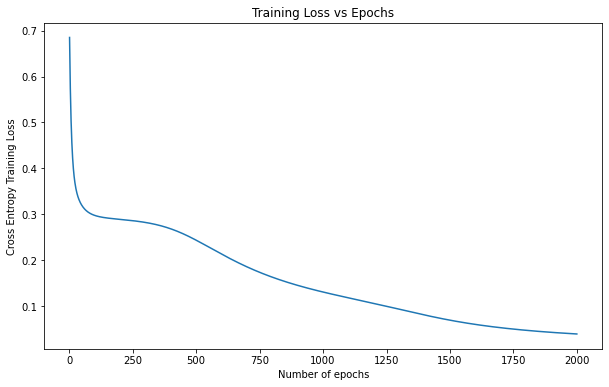

In [174]:
plt.figure(figsize=(10,6))
plt.plot(range(1,2001),losses)
plt.title('Training Loss vs Epochs')
plt.xlabel('Number of epochs')
plt.ylabel('Cross Entropy Training Loss')
plt.show()

As we can see the Cross Entropy Loss converges to a value of approximately 0.031 as the number of epochs increases. 

In [175]:
predictions = predict(model, X)

Total number of predictions that are correct.

In [176]:
(predictions == y).sum()

199

The training predictions only fail to classify one single instance.

Let's check the weights and biases of the optimized network:

In [177]:
model['W1']

array([[-1.71416628, -1.85642682, -3.96073072],
       [ 1.55883829,  0.91151374, -2.13302923]])

In [178]:
model['b1']

array([[ 2.16641102, -1.01659747,  2.02715264]])

In [179]:
model['W2']

array([[ 3.02616984, -3.22135009],
       [ 3.21801739, -3.64682404],
       [-3.00877931,  3.36035723]])

In [180]:
model['b2']

array([[ 0.05431289, -0.05431289]])

## Cross Validation Approach for Training

In [45]:
X.shape, y.shape

((200, 2), (200,))

**Split the dataset** 

In [118]:
''' Function that splits the dataset into n folds
    Inputs: x -> input data
            y -> target labels
            n_folds = number of folds
    Outputs: splitted_dataset -> dataset splitted into n folds'''

def split_dataset(x,y,n_folds):
    #Concatenate the input and target arrays
    dataset = np.ones((x.shape[0],x.shape[1]+1))
    dataset[:,0:x.shape[1]] = x
    dataset[:,x.shape[1]] = y
    #Split the dataset into n folds
    splitted_dataset = np.split(dataset, n_folds, axis = 0)
    
    return splitted_dataset

In [132]:
def backpropagation_with_CV(x, y, input_dim, hidden_dim, output_dim, epochs, n_folds):
    training_losses= []
    test_scores = []
    networks = []
    
    #Split the dataset into n folds
    splitted_dataset = split_dataset(x, y, n_folds)
    
    #Define the train and test sets for each cross validation step
    for i in range(n_folds):
        indices = list(range(n_folds))
        indices.remove(i)
        train_indices = indices
        test_index = i
        #Training Set
        train_set = splitted_dataset[train_indices[0]]
        for j in train_indices[1:]:
            train_set = np.concatenate((train_set, splitted_dataset[j]), axis = 0)
            
        #Test Set
        test_set = splitted_dataset[test_index]
        
        #Input Data fror training
        x_train = train_set[:,:x.shape[1]]  
        #Labels for training
        y_train = train_set[:,x.shape[1]].astype(int)    
        
        #Input Data for testing
        x_test = test_set[:,:x.shape[1]]   
        #Labels for testing
        y_test = test_set[:,x.shape[1]].astype(int)    
        
        #Initialize the weights of the network creating the model dictionary
        model_dict = init_network(input_dim, hidden_dim, output_dim)
        #For every distinct epoch
        for i in range(epochs):             
            #Pre-updated weights and biases
            W1, b1, W2, b2 = retrieve(model_dict)
            #Forward Propagation
            z1, a1, probs = forward(x_train, model_dict) 
        
            ### Definition of the backpropagation terms ###
            delta3 = np.copy(probs)
            delta3[range(x_train.shape[0]), y_train] -= 1   #(200x2)
            #Derivative of the cost function with respect to the weights
            #of the second layer 
            dW2 = (a1.T).dot(delta3)  #a1: (3,200)*(200,2)-->(3,2)
            #Derivative of the cost function with respect to the second layer bias terms
            db2 = np.sum(delta3, axis = 0, keepdims = True)   # (1,2)
        
            delta2 = delta3.dot(W2.T) * (1-np.power(np.tanh(z1), 2))
            #Derivative of the cost function with respect to the weights
            #of the first layer 
            dW1 = np.dot(x_train.T,delta2)
            #Derivative of the cost function with respect to the first layer bias terms
            db1 = np.sum(delta2, axis = 0)
            #Add regularization terms
            dW2 += lambda_reg * np.sum(W2)
            dW1 += lambda_reg * np.sum(W1)
        
            ### Update Weights ###
            # W = W - lr*gradient
            W1 += -learning_rate * dW1  
            b1 += -learning_rate * db1
            W2 += -learning_rate * dW2
            b2 += -learning_rate * db2
            
            #Update the model dictionary
            model_dict = {'W1':W1, 'b1':b1, 'W2':W2, 'b2':b2}
            
            #Save the training loss value for each epoch
            training_losses.append(loss(probs, y_train, model_dict))
            
            #Calculate the predictions for each epoch
            y_pred = predict(model_dict, x_test)
            #Calculate the test F1-Score
            f1score = f1_score(y_test, y_pred)
            #Save the test f1_score for each epoch
            test_scores.append(f1score)
        
        #Save the optimized network for each fold
        networks.append(model_dict)
        
    return networks, training_losses, test_scores                

In [165]:
networks, training_losses, test_scores = backpropagation_with_CV(X, y, input_neurons, 3, output_neurons, 2000, 4)

Now we have the evolution of the training Cross Entropy Loss and the test F1 score for every fold of data. Let's plot them all now.

In [166]:
epochs = 2000
#Fold 1 Training Loss evolution
training_losses_1 = training_losses[0:epochs]
#Fold 2 Training Loss evolution
training_losses_2 = training_losses[epochs:2*epochs]
#Fold 3 Training Loss evolution
training_losses_3 = training_losses[2*epochs:3*epochs]
#Fold 4 Training Loss evolution
training_losses_4 = training_losses[3*epochs:4*epochs]

In [167]:
#Fold 1 Test F1 Score evolution
test_scores_1 = test_scores[0:epochs]
#Fold 2 Test F1 Score evolution
test_scores_2 = test_scores[epochs:2*epochs]
#Fold 3 Test F1 Score evolution
test_scores_3 = test_scores[2*epochs:3*epochs]
#Fold 4 test F1 Score evolution
test_scores_4 = test_scores[3*epochs:4*epochs]

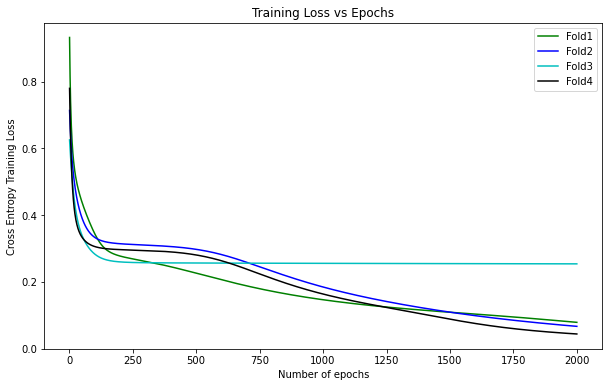

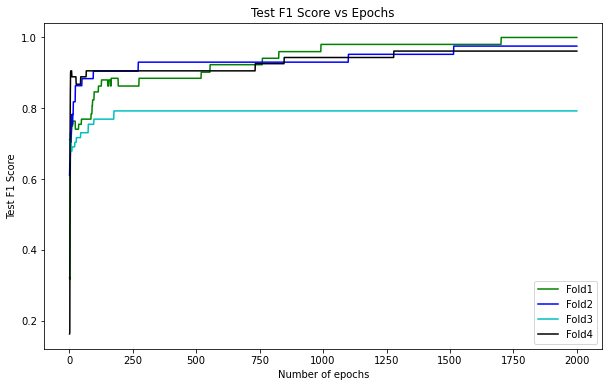

In [168]:
#Training Loss Graphs
plt.figure(figsize=(10,6))
x = range(1,epochs+1)
plt.plot(x, training_losses_1, 'g',
         x, training_losses_2, 'b',
         x, training_losses_3, 'c',
         x, training_losses_4, 'k')
plt.legend(['Fold1', 'Fold2', 'Fold3', 'Fold4'])
plt.title('Training Loss vs Epochs')
plt.xlabel('Number of epochs')
plt.ylabel('Cross Entropy Training Loss')
plt.show()

#Test F1 Score Graphs
plt.figure(figsize=(10,6))
x = range(1,epochs+1)
plt.plot(x, test_scores_1, 'g',
         x, test_scores_2, 'b',
         x, test_scores_3, 'c',
         x, test_scores_4, 'k')

plt.legend(['Fold1', 'Fold2', 'Fold3', 'Fold4'])
plt.title('Test F1 Score vs Epochs')
plt.xlabel('Number of epochs')
plt.ylabel('Test F1 Score')
plt.show()



- The optimization for the fold 3 got stuck in a local minimum, since the training loss converged for a value much larger than the other folds. 
- In general the network is generalizing pretty well, since the test F1 Score has almost unitary values. 
- The test F1-Score is always increasing so the model is not overfitting

## Decision Boundary

In [159]:
def plot_decision_boundary(pred_func):
    #Set min and max values and give it some padding
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    h = 0.01
    #Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    #Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Plot the contour and training examples
    plt.contourf(xx,yy,Z,cmap=plt.cm.Spectral)
    plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Spectral)
    plt.title('Decision Boundary')

**Model trained with the full dataset**

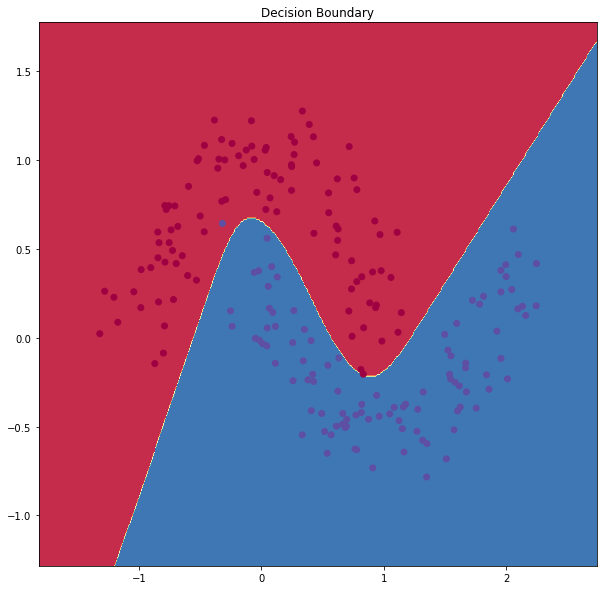

In [181]:
plt.figure(figsize=[10,10])
plot_decision_boundary(lambda x: predict(model, x))

**Model trained in the first fold**

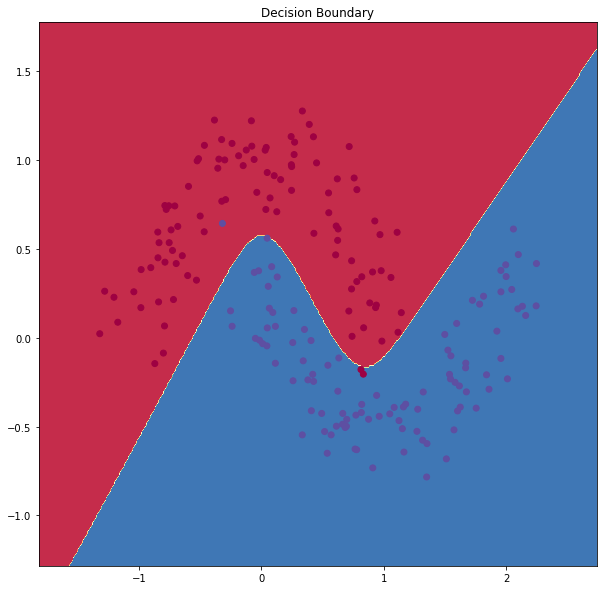

In [184]:
plt.figure(figsize=[10,10])
plot_decision_boundary(lambda x: predict(networks[0], x))

**Model trained in the second fold**

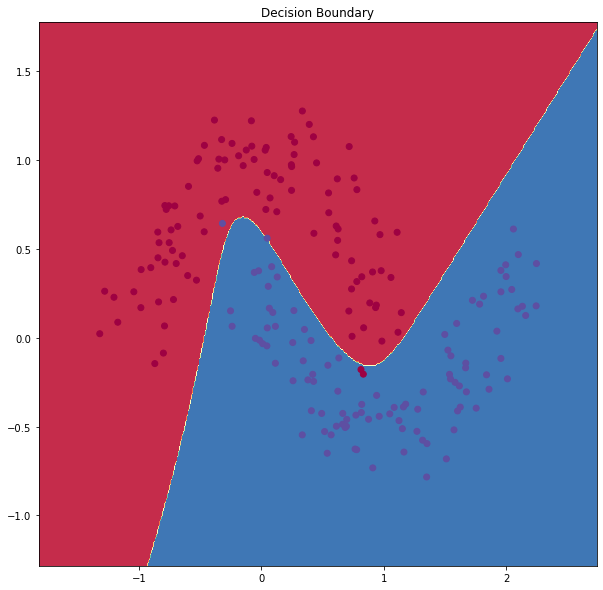

In [185]:
plt.figure(figsize=[10,10])
plot_decision_boundary(lambda x: predict(networks[1], x))

**Model trained in the third fold (the one who got stuck in a local minimum)**

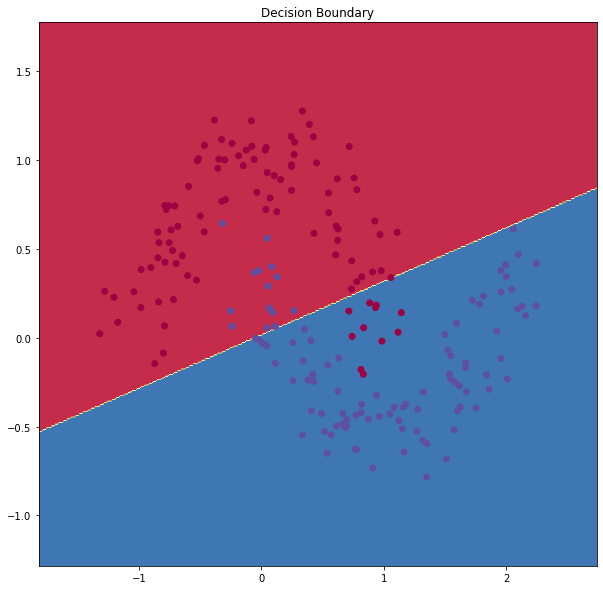

In [186]:
plt.figure(figsize=[10,10])
plot_decision_boundary(lambda x: predict(networks[2], x))

**Model trained in the fourth fold**

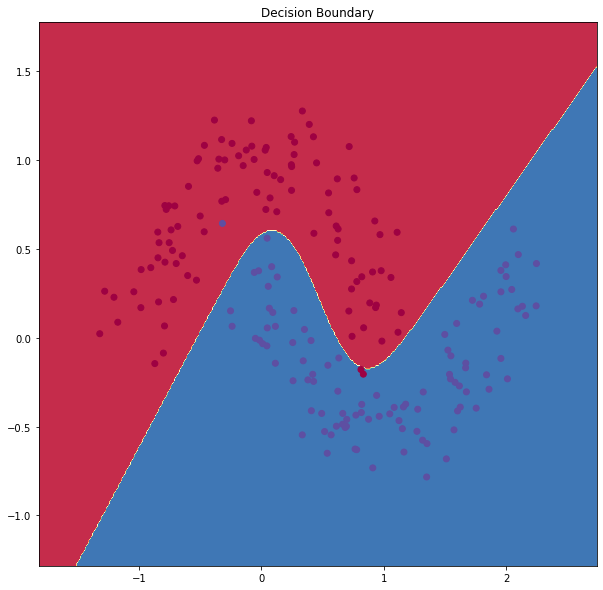

In [187]:
plt.figure(figsize=[10,10])
plot_decision_boundary(lambda x: predict(networks[3], x))

## Forcing Overfitting

Now the goal is to force overfitting in order to look at the decision boundary of the network. In order to try that I decided to create a network with 200 hidden layer neurons and increase the number of epochs to 6000.

In [205]:
networks, training_losses, test_scores = backpropagation_with_CV(X, y, input_neurons, 200, output_neurons, 6000, 4)

In [206]:
epochs = 6000
#Fold 1 Training Loss evolution
training_losses_1 = training_losses[0:epochs]
#Fold 2 Training Loss evolution
training_losses_2 = training_losses[epochs:2*epochs]
#Fold 3 Training Loss evolution
training_losses_3 = training_losses[2*epochs:3*epochs]
#Fold 4 Training Loss evolution
training_losses_4 = training_losses[3*epochs:4*epochs]

In [207]:
#Fold 1 Test F1 Score evolution
test_scores_1 = test_scores[0:epochs]
#Fold 2 Test F1 Score evolution
test_scores_2 = test_scores[epochs:2*epochs]
#Fold 3 Test F1 Score evolution
test_scores_3 = test_scores[2*epochs:3*epochs]
#Fold 4 test F1 Score evolution
test_scores_4 = test_scores[3*epochs:4*epochs]

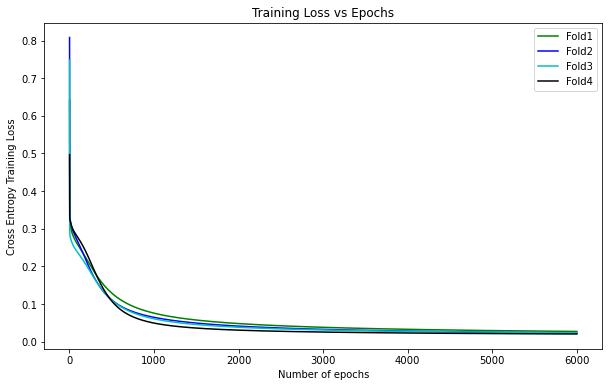

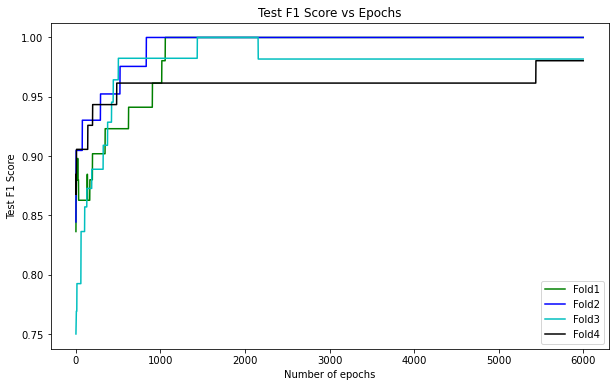

In [208]:
#Training Loss Graphs
plt.figure(figsize=(10,6))
x = range(1,epochs+1)
plt.plot(x, training_losses_1, 'g',
         x, training_losses_2, 'b',
         x, training_losses_3, 'c',
         x, training_losses_4, 'k')
plt.legend(['Fold1', 'Fold2', 'Fold3', 'Fold4'])
plt.title('Training Loss vs Epochs')
plt.xlabel('Number of epochs')
plt.ylabel('Cross Entropy Training Loss')
plt.show()

#Test F1 Score Graphs
plt.figure(figsize=(10,6))
x = range(1,epochs+1)
plt.plot(x, test_scores_1, 'g',
         x, test_scores_2, 'b',
         x, test_scores_3, 'c',
         x, test_scores_4, 'k')

plt.legend(['Fold1', 'Fold2', 'Fold3', 'Fold4'])
plt.title('Test F1 Score vs Epochs')
plt.xlabel('Number of epochs')
plt.ylabel('Test F1 Score')
plt.show()


The model is still not overfitting for all the folds, since the test F1 scores are not decrasing after a certain number of epochs. 

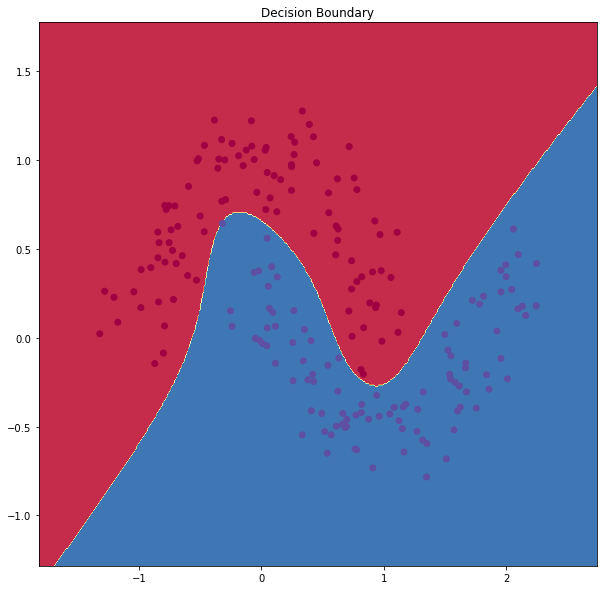

In [209]:
plt.figure(figsize=[10,10])
plot_decision_boundary(lambda x: predict(networks[0], x))

It's clear a visible change in the decision boundary for this model comparing to the previous ones.